# One Pixel Attack Tutorial

![](images/horse.png "I'm a normal horse, nothing suspicious here") ![](images/horse-attack.png "I'm an attack horse, grr")

### Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from keras.datasets import cifar10
from scipy.optimize import differential_evolution
from scipy.stats import truncnorm
from IPython.display import clear_output

/home/hyper/Documents/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
from networks.lecun_net import LecunNet
from networks.pure_cnn import PureCnn
from networks.wide_resnet import WideResNet
from networks.network_in_network import NetworkInNetwork
from helper import get_class_names, plot_image

In [8]:
matplotlib.style.use('ggplot')

### Load Data

Load the Cifar10 dataset and all necessary metadata.

In [9]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [10]:
# Obtain the names of the 10 classes in cifar10
class_names = get_class_names()
print(class_names)

Decoding file: data/batches.meta
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Load Models

Load various pretrained Neural Network models in the `networks/models` directory.

Keras will need to also download the Cifar10 dataset if it is not cached locally already.

In [12]:
lecun_net = LecunNet()
pure_cnn = PureCnn()
net_in_net = NetworkInNetwork()
# resnet = ResNet()
wide_resnet = WideResNet()

models = [lecun_net, pure_cnn, net_in_net, wide_resnet]

# These networks don't have pretrained models due to their size and training time, 
# so they are commented out. They can be trained with the train() function.

# vgg16 = VGG16()
# vgg19 = VGG19()
# resnext = ResNeXt()
# senet = SENet()

Successfully loaded lecun_net
Successfully loaded pure_cnn
Successfully loaded net_in_net
Successfully loaded wide_resnet


### Calculate Model Accuracies

In [13]:
final_results = pd.DataFrame(columns=['name', 'accuracy', 'param_count'], data=[
    [model.name, model.accuracy(), model.param_count]
    for model in models])

In [14]:
final_results

,name,accuracy,param_count
0,lecun_net,0.7488,62006
1,pure_cnn,0.8877,1369738
2,net_in_net,0.9074,972658
3,wide_resnet,0.9534,11318026


### Image Perturbation

In [9]:
def perturb_image(x, img):
    img = np.copy(img)
    pixels = np.split(x.astype(int), len(x) // 5)
    for x in pixels:
        x_pos, y_pos, rgb = *x[:2], x[2:]
        img[x_pos][y_pos] = rgb
    return img

In [10]:
def predict_untargeted(x, *args):
    img, correct_class, model = args
    img_perturbed = perturb_image(x, img)
    prediction = model.predict(img_perturbed)
    return prediction[correct_class]

In [11]:
def predict_targeted(x, *args):
    img, target_class, model = args
    img_perturbed = perturb_image(x, img)
    prediction = model.predict(img_perturbed)
    return 1 - prediction[target_class]

### Untargeted Attack

The objective of an untargeted attack is to cause a model to misclassify an image. This means we want to minimize the probability of the correct classification category and maximize the sum of the probabilities of all other categories.

In [46]:
def attack_untargeted_iteration(img, model, pixel_count=1, iterations=30,
                                population=100, mutation=0.5, recombination=0.7, 
                                stop_threshold=-0.01, callback=None):
    print('Attacking image', img)
    
    args = x_test[img], y_test[img], model
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    attack = predict_untargeted

    cb = None if callback == None else lambda x,convergence: callback(x, convergence, args)
    disp = callback == None
    
    res = differential_evolution(attack, bounds, args=args, maxiter=iterations, popsize=population, mutation=0.5, recombination=1, atol=stop_threshold, disp=disp, callback=cb)

    attack_image = perturb_image(res.x, x_test[img])
    predicted_probs = model.predict(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img][0]
    success = predicted_class != actual_class

    plot_image(attack_image, actual_class, class_names, predicted_class)

    return [img, actual_class, predicted_class, success, predicted_probs, attack_image]

In [47]:
def untargeted_callback(x, convergence, args):
    img, correct_class, model = args
    correct_class = correct_class[0]
    img_perturbed = perturb_image(x, img)
    confidence = model.predict(img_perturbed)
    prediction = np.argmax(confidence)
    print('Confidence:', confidence[correct_class])
    if (prediction != correct_class):
        return True # Do it this way because returning it directly will prevent early halting

Attacking image 99
Confidence: 0.9765877
Confidence: 0.9765877
Confidence: 0.8886552
Confidence: 0.49795097


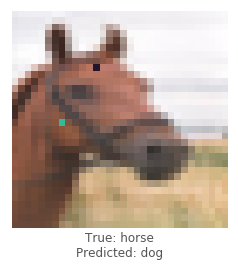

In [48]:
_ = attack_untargeted_iteration(99, wide_resnet, pixel_count=2, callback=untargeted_callback)

In [49]:
def attack_untargeted(model, pixel_count=1, sample_count=100, iterations=30,
                      population=100, mutation=0.5, recombination=1, 
                      stop_threshold=-0.01, callback=untargeted_callback):
    print('Targeting model', model.name)
    
    samples = np.random.choice(len(x_test), sample_count)
    
    results = []
    for i,img in enumerate(samples):
        print('Sample', i)
        result = attack_untargeted_iteration(
            img, model, pixel_count, iterations,
            population, mutation, recombination, 
            stop_threshold, callback)
        results.append(result)
        print()
    
    return pd.DataFrame(
        data=results,
        columns=['image_index', 'true_class', 'predicted_class', 'success', 'predicted_probs', 'attack_image']
    )

Targeting model wide_resnet
Iteration 0
Attacking image 6662
Confidence: 0.06800787


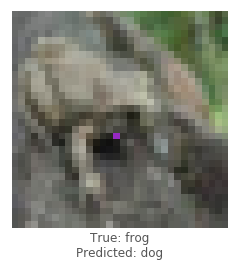


Iteration 1
Attacking image 1223
Confidence: 0.9999286
Confidence: 0.9999056
Confidence: 0.9999056
Confidence: 0.9998815
Confidence: 0.99986696
Confidence: 0.9998654
Confidence: 0.9998654
Confidence: 0.9998647
Confidence: 0.9998647
Confidence: 0.9998647
Confidence: 0.9998646
Confidence: 0.9998646
Confidence: 0.9998646
Confidence: 0.9998646
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446
Confidence: 0.99986446


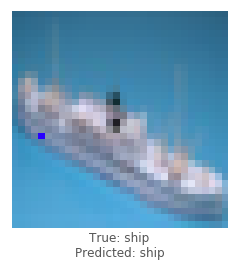


Iteration 2
Attacking image 3358
Confidence: 0.9909355
Confidence: 0.982907
Confidence: 0.98085004
Confidence: 0.9601557
Confidence: 0.9561567
Confidence: 0.9561567
Confidence: 0.9460796
Confidence: 0.9460796
Confidence: 0.9460796
Confidence: 0.9460796
Confidence: 0.9460796
Confidence: 0.9460796
Confidence: 0.9460796
Confidence: 0.9460796
Confidence: 0.9460796
Confidence: 0.9460164
Confidence: 0.9460164
Confidence: 0.94596016
Confidence: 0.94596016
Confidence: 0.94596016
Confidence: 0.94596016
Confidence: 0.94596016
Confidence: 0.94596016
Confidence: 0.94596016
Confidence: 0.94596016
Confidence: 0.94596016
Confidence: 0.94596016
Confidence: 0.94596016
Confidence: 0.94596016
Confidence: 0.94596016


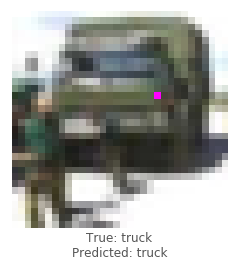


Iteration 3
Attacking image 8969
Confidence: 0.9999987
Confidence: 0.9999981
Confidence: 0.9999976
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714
Confidence: 0.99999714


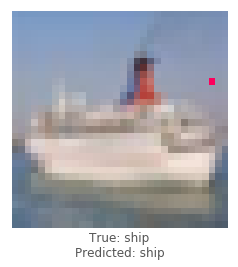


Iteration 4
Attacking image 242
Confidence: 0.54335105
Confidence: 0.45349857


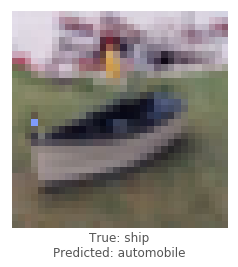


Iteration 5
Attacking image 8714
Confidence: 0.99286133
Confidence: 0.97499824
Confidence: 0.9455835
Confidence: 0.94273895
Confidence: 0.94273895
Confidence: 0.9341543
Confidence: 0.9320416
Confidence: 0.9317245
Confidence: 0.9309782
Confidence: 0.93060887
Confidence: 0.93060887
Confidence: 0.9305272
Confidence: 0.9305272
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056
Confidence: 0.9305056


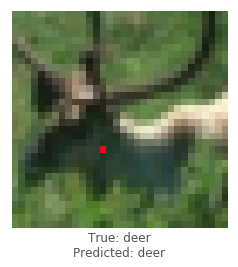


Iteration 6
Attacking image 1105
Confidence: 0.00024960208


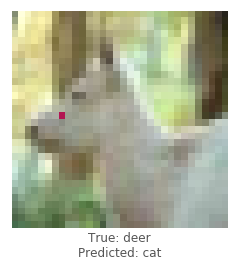


Iteration 7
Attacking image 6831
Confidence: 0.9997042
Confidence: 0.9997042
Confidence: 0.99961436
Confidence: 0.9995746
Confidence: 0.9995683
Confidence: 0.9995497
Confidence: 0.9995448
Confidence: 0.9995389
Confidence: 0.9995353
Confidence: 0.9995334
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527
Confidence: 0.999527


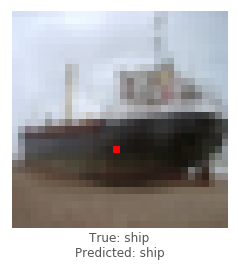


Iteration 8
Attacking image 8024
Confidence: 0.9969797
Confidence: 0.9962708
Confidence: 0.99622774
Confidence: 0.99622774
Confidence: 0.9961045
Confidence: 0.99596775
Confidence: 0.9959099
Confidence: 0.9959091
Confidence: 0.99589396
Confidence: 0.9958925
Confidence: 0.9958722
Confidence: 0.99587184
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934


/home/hyper/Documents/anaconda3/lib/python3.6/site-packages/scipy/optimize/_differentialevolution.py:533: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934
Confidence: 0.99586934


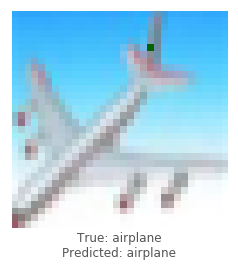


Iteration 9
Attacking image 344
Confidence: 0.99881387
Confidence: 0.9986278
Confidence: 0.9985953
Confidence: 0.9985846
Confidence: 0.99855906
Confidence: 0.99855906
Confidence: 0.99854076
Confidence: 0.99854076
Confidence: 0.9985404
Confidence: 0.9985404
Confidence: 0.9985399
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398
Confidence: 0.9985398


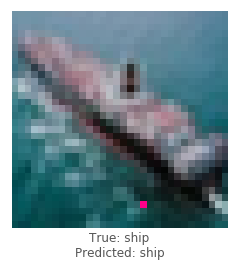


Iteration 10
Attacking image 8864
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999962
Confidence: 0.9999957
Confidence: 0.9999956
Confidence: 0.9999932
Confidence: 0.9999919
Confidence: 0.9999914
Confidence: 0.9999912
Confidence: 0.9999912
Confidence: 0.9999912
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.99999106


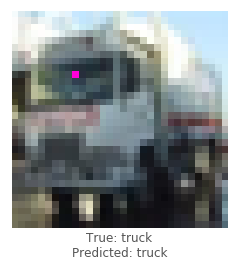


Iteration 11
Attacking image 8530
Confidence: 0.99997306
Confidence: 0.99994195
Confidence: 0.99991906
Confidence: 0.99991906
Confidence: 0.99989927
Confidence: 0.99985075
Confidence: 0.9998468
Confidence: 0.9998468
Confidence: 0.9998424
Confidence: 0.99984217
Confidence: 0.999841
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026
Confidence: 0.99984026


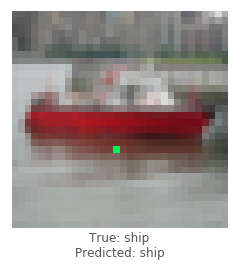


Iteration 12
Attacking image 6426
Confidence: 0.9999981
Confidence: 0.9999981
Confidence: 0.9999981
Confidence: 0.9999981
Confidence: 0.9999981
Confidence: 0.99999785
Confidence: 0.9999975
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.9999974


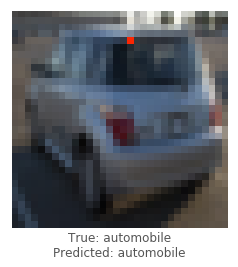


Iteration 13
Attacking image 721
Confidence: 0.99868435
Confidence: 0.99830973
Confidence: 0.99818915
Confidence: 0.998054
Confidence: 0.9979651
Confidence: 0.9979468
Confidence: 0.9979371
Confidence: 0.9979371
Confidence: 0.9979321
Confidence: 0.9979321
Confidence: 0.9979321
Confidence: 0.9979315
Confidence: 0.9979315
Confidence: 0.9979315
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136
Confidence: 0.99793136


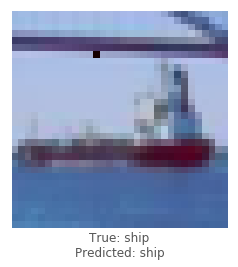


Iteration 14
Attacking image 7692
Confidence: 0.9999124
Confidence: 0.99991226
Confidence: 0.9998944
Confidence: 0.9998808
Confidence: 0.9997814
Confidence: 0.9997814
Confidence: 0.9997745
Confidence: 0.9997664
Confidence: 0.99976236
Confidence: 0.99975115
Confidence: 0.999747
Confidence: 0.99974376
Confidence: 0.99974376
Confidence: 0.99974364
Confidence: 0.99974364
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435
Confidence: 0.9997435


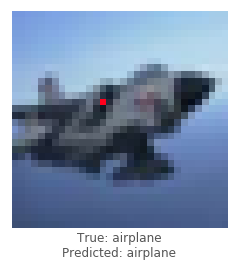


Iteration 15
Attacking image 6214
Confidence: 0.9986266
Confidence: 0.9986148
Confidence: 0.9985884
Confidence: 0.9983443
Confidence: 0.9982015
Confidence: 0.9981974
Confidence: 0.9981974
Confidence: 0.99818736
Confidence: 0.9981667
Confidence: 0.9981667
Confidence: 0.9981633
Confidence: 0.9981528
Confidence: 0.9981528
Confidence: 0.9981528
Confidence: 0.9981528
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243
Confidence: 0.99815243


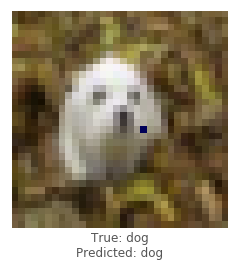


Iteration 16
Attacking image 3143
Confidence: 0.99998605
Confidence: 0.99998605
Confidence: 0.99998605
Confidence: 0.9999838
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295
Confidence: 0.99998295


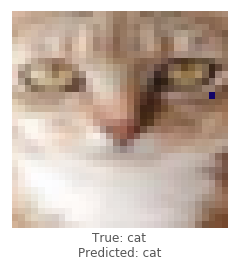


Iteration 17
Attacking image 6559
Confidence: 0.27595958


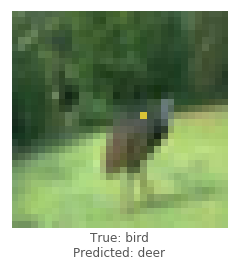


Iteration 18
Attacking image 6175
Confidence: 0.8414955
Confidence: 0.8111938
Confidence: 0.7769272
Confidence: 0.7652893
Confidence: 0.74418306
Confidence: 0.74418306
Confidence: 0.74418306
Confidence: 0.74342304
Confidence: 0.7423668
Confidence: 0.7411415
Confidence: 0.7409872
Confidence: 0.74055856
Confidence: 0.74055856
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784
Confidence: 0.74050784


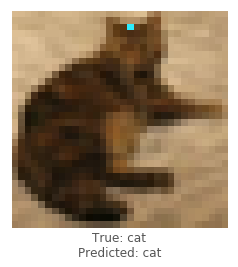


Iteration 19
Attacking image 6330
Confidence: 0.9997459
Confidence: 0.9997459
Confidence: 0.9996911
Confidence: 0.99960023
Confidence: 0.99960023
Confidence: 0.99960023
Confidence: 0.99958163
Confidence: 0.99958163
Confidence: 0.9995757
Confidence: 0.99957496
Confidence: 0.99957377
Confidence: 0.9995696
Confidence: 0.99956924
Confidence: 0.9995691
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569
Confidence: 0.999569


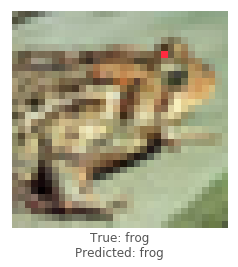


Iteration 20
Attacking image 7021
Confidence: 0.9890633
Confidence: 0.9876973
Confidence: 0.9702526
Confidence: 0.9702526
Confidence: 0.96696603
Confidence: 0.96194935
Confidence: 0.96072656
Confidence: 0.96048695
Confidence: 0.9600179
Confidence: 0.9600179
Confidence: 0.9600179
Confidence: 0.95919573
Confidence: 0.95919573
Confidence: 0.95919573
Confidence: 0.95919573
Confidence: 0.95919573
Confidence: 0.9591738
Confidence: 0.9591696
Confidence: 0.9591696
Confidence: 0.9591666
Confidence: 0.9591666
Confidence: 0.9591666
Confidence: 0.9591666
Confidence: 0.9591666
Confidence: 0.9591666
Confidence: 0.9591666
Confidence: 0.9591666
Confidence: 0.9591666
Confidence: 0.9591666
Confidence: 0.9591666


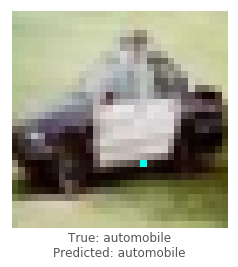


Iteration 21
Attacking image 3379
Confidence: 0.9973694
Confidence: 0.9968912
Confidence: 0.9930038
Confidence: 0.9920923
Confidence: 0.99077374
Confidence: 0.99077374
Confidence: 0.99077374
Confidence: 0.99077374
Confidence: 0.977099
Confidence: 0.9760243
Confidence: 0.97434956
Confidence: 0.96266973
Confidence: 0.95842606
Confidence: 0.95842606
Confidence: 0.9569971
Confidence: 0.9569971
Confidence: 0.9552101
Confidence: 0.9552101
Confidence: 0.9537646
Confidence: 0.95340985
Confidence: 0.95340985
Confidence: 0.95340985
Confidence: 0.95340985
Confidence: 0.95340985
Confidence: 0.95340985
Confidence: 0.95340985
Confidence: 0.95340985
Confidence: 0.95340985
Confidence: 0.95340985
Confidence: 0.95340985


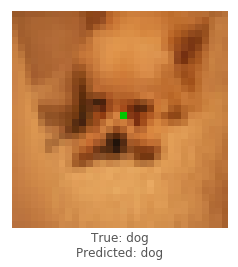


Iteration 22
Attacking image 1259
Confidence: 0.99932027
Confidence: 0.99932027
Confidence: 0.99932027
Confidence: 0.99915874
Confidence: 0.99445844
Confidence: 0.99433315
Confidence: 0.99404305
Confidence: 0.9928598
Confidence: 0.9924401
Confidence: 0.9924401
Confidence: 0.9920853
Confidence: 0.9920853
Confidence: 0.99205387
Confidence: 0.991954
Confidence: 0.991954
Confidence: 0.991954
Confidence: 0.991954
Confidence: 0.991954
Confidence: 0.991954
Confidence: 0.99195147
Confidence: 0.99195147
Confidence: 0.99195147
Confidence: 0.99195147
Confidence: 0.99195147
Confidence: 0.99195147
Confidence: 0.99195147
Confidence: 0.99195147
Confidence: 0.99195147
Confidence: 0.99195147
Confidence: 0.99195147


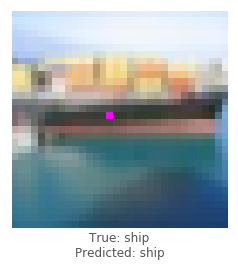


Iteration 23
Attacking image 5683
Confidence: 0.9999435
Confidence: 0.9999224
Confidence: 0.9999224
Confidence: 0.9999187
Confidence: 0.9999187
Confidence: 0.99991786
Confidence: 0.99991786
Confidence: 0.99991786
Confidence: 0.9999176
Confidence: 0.9999168
Confidence: 0.9999168
Confidence: 0.9999168
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167
Confidence: 0.9999167


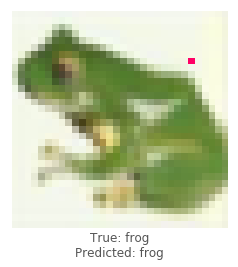


Iteration 24
Attacking image 7726
Confidence: 0.999954
Confidence: 0.99993396
Confidence: 0.99990964
Confidence: 0.9998523
Confidence: 0.9998349
Confidence: 0.9998223
Confidence: 0.9998223
Confidence: 0.9998223
Confidence: 0.99982053
Confidence: 0.9998204
Confidence: 0.99982005
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993
Confidence: 0.99981993


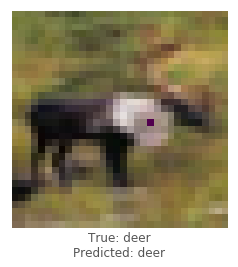


Iteration 25
Attacking image 759
Confidence: 0.999998
Confidence: 0.9999974
Confidence: 0.9999974
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726
Confidence: 0.99999726


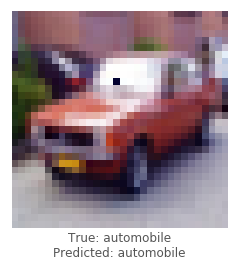


Iteration 26
Attacking image 8127
Confidence: 0.99518555
Confidence: 0.9951499
Confidence: 0.99189574
Confidence: 0.99189574
Confidence: 0.99189574
Confidence: 0.99189574
Confidence: 0.99183226
Confidence: 0.991682
Confidence: 0.9916265
Confidence: 0.991531
Confidence: 0.99149245
Confidence: 0.99149245
Confidence: 0.99148303
Confidence: 0.99148303
Confidence: 0.99148303
Confidence: 0.99148303
Confidence: 0.99148303
Confidence: 0.99148303
Confidence: 0.99148303
Confidence: 0.99148303
Confidence: 0.99148303
Confidence: 0.99148303
Confidence: 0.99148303
Confidence: 0.99148303
Confidence: 0.99148303
Confidence: 0.99148303
Confidence: 0.99148303
Confidence: 0.99148303
Confidence: 0.99148303
Confidence: 0.99148303


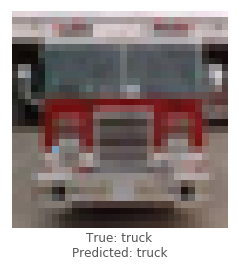


Iteration 27
Attacking image 8575
Confidence: 0.99991214
Confidence: 0.99991214
Confidence: 0.9998772
Confidence: 0.99985194
Confidence: 0.9998417
Confidence: 0.99983895
Confidence: 0.9998369
Confidence: 0.99983
Confidence: 0.9998294
Confidence: 0.99982685
Confidence: 0.99982685
Confidence: 0.99982446
Confidence: 0.99982446
Confidence: 0.99982446
Confidence: 0.99982446
Confidence: 0.99982446
Confidence: 0.99982446
Confidence: 0.99982446
Confidence: 0.99982446
Confidence: 0.99982446
Confidence: 0.99982446
Confidence: 0.99982446
Confidence: 0.99982446
Confidence: 0.99982446
Confidence: 0.99982446
Confidence: 0.99982446
Confidence: 0.99982446
Confidence: 0.99982446
Confidence: 0.99982446
Confidence: 0.99982446


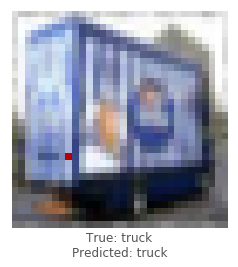


Iteration 28
Attacking image 8465
Confidence: 0.009082277


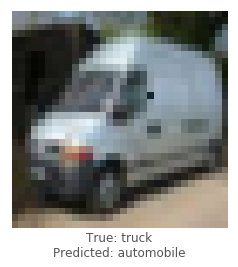


Iteration 29
Attacking image 6410
Confidence: 0.99997115
Confidence: 0.99996924
Confidence: 0.999969
Confidence: 0.9999685
Confidence: 0.9999684
Confidence: 0.9999684
Confidence: 0.9999684
Confidence: 0.9999684
Confidence: 0.9999684
Confidence: 0.9999684
Confidence: 0.9999683
Confidence: 0.9999683
Confidence: 0.9999683
Confidence: 0.9999683
Confidence: 0.9999683
Confidence: 0.9999683
Confidence: 0.9999683
Confidence: 0.9999683
Confidence: 0.9999683
Confidence: 0.9999683
Confidence: 0.9999683
Confidence: 0.9999683
Confidence: 0.9999683
Confidence: 0.9999683
Confidence: 0.9999683
Confidence: 0.9999683
Confidence: 0.9999683
Confidence: 0.9999683
Confidence: 0.9999683
Confidence: 0.9999683


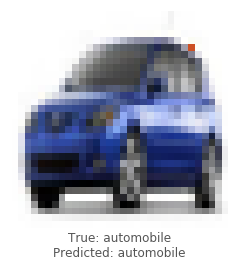


Iteration 30
Attacking image 7159
Confidence: 0.9998708
Confidence: 0.9998708
Confidence: 0.999795
Confidence: 0.9997497
Confidence: 0.99972206
Confidence: 0.9997209
Confidence: 0.9997209
Confidence: 0.9997209
Confidence: 0.9997209
Confidence: 0.9997209
Confidence: 0.9997204
Confidence: 0.9997173
Confidence: 0.99971706
Confidence: 0.99971515
Confidence: 0.99971515
Confidence: 0.99971515
Confidence: 0.99971515
Confidence: 0.99971515
Confidence: 0.99971515
Confidence: 0.99971515
Confidence: 0.99971515
Confidence: 0.99971515
Confidence: 0.99971515
Confidence: 0.99971515
Confidence: 0.99971515
Confidence: 0.99971515
Confidence: 0.99971515
Confidence: 0.99971515
Confidence: 0.99971515
Confidence: 0.99971515


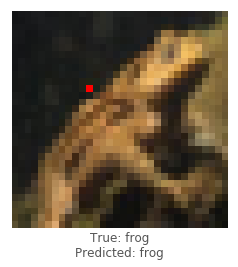


Iteration 31
Attacking image 9844
Confidence: 0.9922867
Confidence: 0.9922867
Confidence: 0.9469015
Confidence: 0.9469015
Confidence: 0.93480456
Confidence: 0.93480456
Confidence: 0.9252127
Confidence: 0.92140275
Confidence: 0.9187836
Confidence: 0.9173459
Confidence: 0.9173459
Confidence: 0.91403526
Confidence: 0.914024
Confidence: 0.914024
Confidence: 0.914024
Confidence: 0.9139785
Confidence: 0.91378874
Confidence: 0.91378874
Confidence: 0.91378874
Confidence: 0.91378874
Confidence: 0.91378874
Confidence: 0.91378874
Confidence: 0.91378874
Confidence: 0.91378874
Confidence: 0.91378874
Confidence: 0.91378874
Confidence: 0.91378874
Confidence: 0.91378874
Confidence: 0.91378874
Confidence: 0.91378874


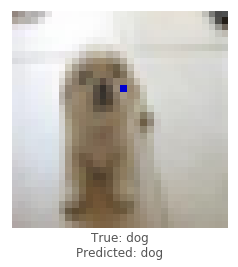


Iteration 32
Attacking image 4012
Confidence: 4.2348416e-05


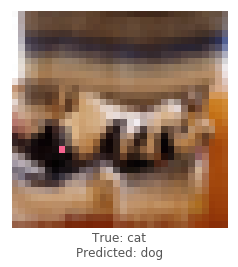


Iteration 33
Attacking image 1020
Confidence: 0.99999094
Confidence: 0.9999901
Confidence: 0.9999893
Confidence: 0.99998915
Confidence: 0.99998903
Confidence: 0.9999889
Confidence: 0.9999888
Confidence: 0.9999888
Confidence: 0.9999887
Confidence: 0.99998856
Confidence: 0.99998856
Confidence: 0.99998856
Confidence: 0.99998856
Confidence: 0.99998856
Confidence: 0.99998856
Confidence: 0.99998856
Confidence: 0.99998856
Confidence: 0.99998856
Confidence: 0.99998856
Confidence: 0.99998856
Confidence: 0.99998856
Confidence: 0.99998856
Confidence: 0.99998856
Confidence: 0.99998856
Confidence: 0.99998856
Confidence: 0.99998856
Confidence: 0.99998856
Confidence: 0.99998856
Confidence: 0.99998856
Confidence: 0.99998856


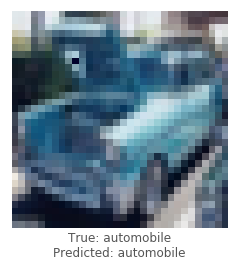


Iteration 34
Attacking image 6402
Confidence: 0.9965358
Confidence: 0.9785194
Confidence: 0.9785194
Confidence: 0.97710115
Confidence: 0.97300434
Confidence: 0.97300434
Confidence: 0.9715808
Confidence: 0.9715808
Confidence: 0.9715808
Confidence: 0.9715808
Confidence: 0.97148424
Confidence: 0.97148424
Confidence: 0.9713017
Confidence: 0.9710833
Confidence: 0.9710833
Confidence: 0.9710833
Confidence: 0.9710833
Confidence: 0.9710833
Confidence: 0.9710833
Confidence: 0.9710833
Confidence: 0.9710833
Confidence: 0.9710833
Confidence: 0.9710833
Confidence: 0.9710833
Confidence: 0.9710833
Confidence: 0.9710833
Confidence: 0.9710833
Confidence: 0.9710833
Confidence: 0.9710833
Confidence: 0.9710833


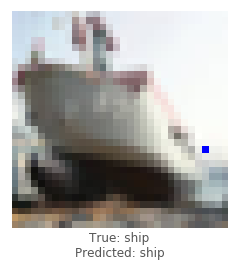


Iteration 35
Attacking image 9541
Confidence: 0.721108
Confidence: 0.4900446


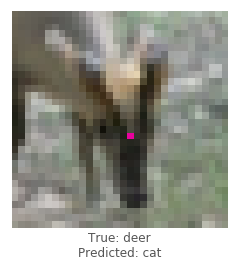


Iteration 36
Attacking image 6876
Confidence: 0.33366826


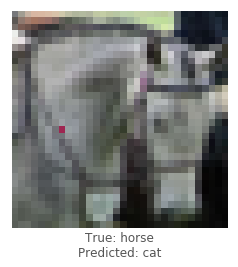


Iteration 37
Attacking image 1776
Confidence: 0.99688065
Confidence: 0.99460924
Confidence: 0.99460924
Confidence: 0.99345374
Confidence: 0.99335384
Confidence: 0.99335384
Confidence: 0.99335384
Confidence: 0.99335384
Confidence: 0.99334806
Confidence: 0.99331313
Confidence: 0.99331313
Confidence: 0.99331313
Confidence: 0.99331313
Confidence: 0.99331313
Confidence: 0.99331313
Confidence: 0.99331313
Confidence: 0.99331313
Confidence: 0.99331313
Confidence: 0.99331313
Confidence: 0.99331313
Confidence: 0.99331313
Confidence: 0.99331313
Confidence: 0.99331313
Confidence: 0.99331313
Confidence: 0.99331313
Confidence: 0.99331313
Confidence: 0.99331313
Confidence: 0.99331313
Confidence: 0.99331313
Confidence: 0.99331313


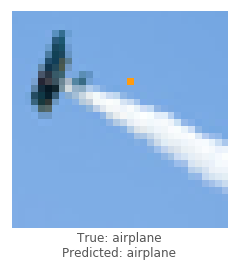


Iteration 38
Attacking image 1034
Confidence: 0.000113127906


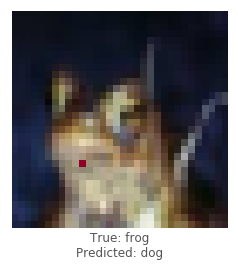


Iteration 39
Attacking image 9445
Confidence: 0.895938
Confidence: 0.895938
Confidence: 0.895938
Confidence: 0.78817403
Confidence: 0.7047611
Confidence: 0.6943773
Confidence: 0.67507803
Confidence: 0.6699742
Confidence: 0.6598521
Confidence: 0.6598521
Confidence: 0.6598521
Confidence: 0.6598521
Confidence: 0.658981
Confidence: 0.65841174
Confidence: 0.65841174
Confidence: 0.65841174
Confidence: 0.65841174
Confidence: 0.65841174
Confidence: 0.65841174
Confidence: 0.65841174
Confidence: 0.65841174
Confidence: 0.65841174
Confidence: 0.65841174
Confidence: 0.65841174
Confidence: 0.65841174
Confidence: 0.65841174
Confidence: 0.65841174
Confidence: 0.65841174
Confidence: 0.65841174
Confidence: 0.65841174


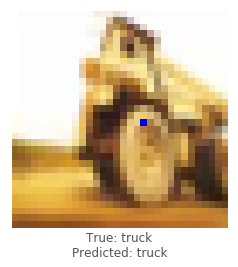


Iteration 40
Attacking image 3913
Confidence: 0.5765234
Confidence: 0.5765234
Confidence: 0.5729446
Confidence: 0.55270445
Confidence: 0.54366565
Confidence: 0.52819407
Confidence: 0.52514404
Confidence: 0.52514404
Confidence: 0.52471936
Confidence: 0.52471936
Confidence: 0.52471936
Confidence: 0.5246336
Confidence: 0.5246336
Confidence: 0.5245068
Confidence: 0.5245068
Confidence: 0.5245068
Confidence: 0.5245068
Confidence: 0.5245068
Confidence: 0.5245068
Confidence: 0.5245068
Confidence: 0.5245068
Confidence: 0.5245068
Confidence: 0.5245068
Confidence: 0.5245068
Confidence: 0.5245068
Confidence: 0.5245068
Confidence: 0.5245068
Confidence: 0.5245068
Confidence: 0.5245068
Confidence: 0.5245068


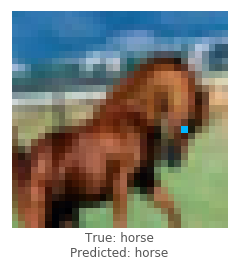


Iteration 41
Attacking image 436
Confidence: 0.8873944
Confidence: 0.8844204
Confidence: 0.8844204
Confidence: 0.8725959
Confidence: 0.87198997
Confidence: 0.87103474
Confidence: 0.8704828
Confidence: 0.869971
Confidence: 0.8698317
Confidence: 0.8698317
Confidence: 0.8698317
Confidence: 0.8698317
Confidence: 0.8698317
Confidence: 0.8698317
Confidence: 0.8698317
Confidence: 0.8698317
Confidence: 0.8698317
Confidence: 0.8698317
Confidence: 0.8698317
Confidence: 0.8698317
Confidence: 0.8698317
Confidence: 0.8698317
Confidence: 0.8698317
Confidence: 0.8698317
Confidence: 0.8698317
Confidence: 0.8698317
Confidence: 0.8698317
Confidence: 0.8698317
Confidence: 0.8698317
Confidence: 0.8698317


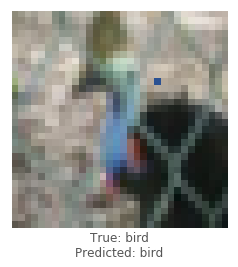


Iteration 42
Attacking image 6180
Confidence: 0.8476997
Confidence: 0.8476997
Confidence: 0.7795179
Confidence: 0.7633124
Confidence: 0.6620338
Confidence: 0.6472885
Confidence: 0.6472885
Confidence: 0.6280515
Confidence: 0.6222491
Confidence: 0.6163626
Confidence: 0.6163626
Confidence: 0.61627454
Confidence: 0.61615515
Confidence: 0.61615515
Confidence: 0.61615515
Confidence: 0.61615515
Confidence: 0.61615515
Confidence: 0.61615515
Confidence: 0.61615515
Confidence: 0.61615515
Confidence: 0.61615515
Confidence: 0.61615515
Confidence: 0.61615515
Confidence: 0.61615515
Confidence: 0.61615515
Confidence: 0.61615515
Confidence: 0.61615515
Confidence: 0.61615515
Confidence: 0.61615515
Confidence: 0.61615515


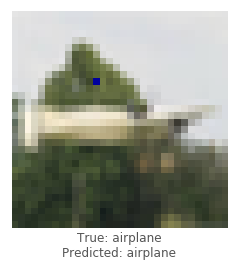


Iteration 43
Attacking image 2260
Confidence: 0.99981123
Confidence: 0.99969494
Confidence: 0.99969494
Confidence: 0.9996853
Confidence: 0.99968004
Confidence: 0.9996791
Confidence: 0.9996791
Confidence: 0.9996791
Confidence: 0.99967027
Confidence: 0.99967027
Confidence: 0.99967027
Confidence: 0.9996666
Confidence: 0.9996666
Confidence: 0.9996666
Confidence: 0.9996666
Confidence: 0.9996666
Confidence: 0.9996666
Confidence: 0.9996666
Confidence: 0.9996666
Confidence: 0.9996666
Confidence: 0.9996666
Confidence: 0.9996666
Confidence: 0.9996666
Confidence: 0.9996666
Confidence: 0.9996666
Confidence: 0.9996666
Confidence: 0.9996666
Confidence: 0.9996666
Confidence: 0.9996666
Confidence: 0.9996666


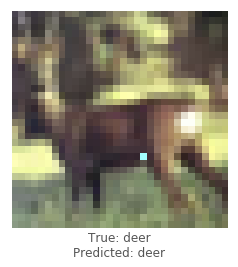


Iteration 44
Attacking image 2020
Confidence: 0.9999776
Confidence: 0.99996686
Confidence: 0.9999645
Confidence: 0.9999645
Confidence: 0.9999645
Confidence: 0.99996305
Confidence: 0.9999627
Confidence: 0.9999597
Confidence: 0.9999553
Confidence: 0.9999553
Confidence: 0.9999553
Confidence: 0.9999553
Confidence: 0.99995506
Confidence: 0.99995506
Confidence: 0.99995506
Confidence: 0.99995506
Confidence: 0.99995494
Confidence: 0.99995494
Confidence: 0.99995494
Confidence: 0.99995494
Confidence: 0.99995494
Confidence: 0.99995494
Confidence: 0.99995494
Confidence: 0.99995494
Confidence: 0.99995494
Confidence: 0.99995494
Confidence: 0.99995494
Confidence: 0.99995494
Confidence: 0.99995494
Confidence: 0.99995494


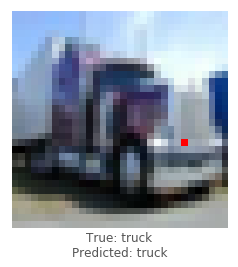


Iteration 45
Attacking image 300
Confidence: 0.99999523
Confidence: 0.99999523
Confidence: 0.9999945
Confidence: 0.9999944
Confidence: 0.99999404
Confidence: 0.99999404
Confidence: 0.9999901
Confidence: 0.99998987
Confidence: 0.9999893
Confidence: 0.99998546
Confidence: 0.99998546
Confidence: 0.99998534
Confidence: 0.99998534
Confidence: 0.99998474
Confidence: 0.99998474
Confidence: 0.99998474
Confidence: 0.99998474
Confidence: 0.99998224
Confidence: 0.99998224
Confidence: 0.99998224
Confidence: 0.99998224
Confidence: 0.99998176
Confidence: 0.99998164
Confidence: 0.99998164
Confidence: 0.99998164
Confidence: 0.99998164
Confidence: 0.9999815
Confidence: 0.9999815
Confidence: 0.9999815
Confidence: 0.9999815


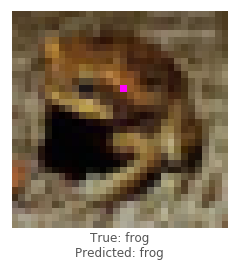


Iteration 46
Attacking image 1173
Confidence: 0.9753034
Confidence: 0.97292715
Confidence: 0.9643425
Confidence: 0.96152085
Confidence: 0.96152085
Confidence: 0.9609033
Confidence: 0.9609033
Confidence: 0.9608454
Confidence: 0.9608454
Confidence: 0.96084076
Confidence: 0.960772
Confidence: 0.9607708
Confidence: 0.9607708
Confidence: 0.9607708
Confidence: 0.9607708
Confidence: 0.9607708
Confidence: 0.9607708
Confidence: 0.9607708
Confidence: 0.9607708
Confidence: 0.9607708
Confidence: 0.9607708
Confidence: 0.9607708
Confidence: 0.9607708
Confidence: 0.9607708
Confidence: 0.9607708
Confidence: 0.9607708
Confidence: 0.9607708
Confidence: 0.9607708
Confidence: 0.9607708
Confidence: 0.9607708


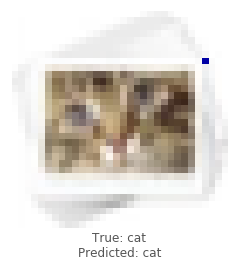


Iteration 47
Attacking image 6367
Confidence: 0.81664693
Confidence: 0.81664693
Confidence: 0.4979096
Confidence: 0.43000102


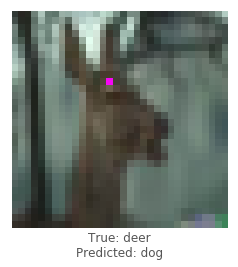


Iteration 48
Attacking image 4758
Confidence: 0.99947697
Confidence: 0.9992242
Confidence: 0.9989704
Confidence: 0.99874437
Confidence: 0.9987369
Confidence: 0.99870586
Confidence: 0.99867636
Confidence: 0.9986552
Confidence: 0.9986492
Confidence: 0.9986492
Confidence: 0.99864894
Confidence: 0.99864894
Confidence: 0.99864894
Confidence: 0.99864894
Confidence: 0.99864894
Confidence: 0.99864894
Confidence: 0.99864894
Confidence: 0.99864894
Confidence: 0.99864894
Confidence: 0.99864894
Confidence: 0.99864894
Confidence: 0.99864894
Confidence: 0.99864894
Confidence: 0.99864894
Confidence: 0.99864894
Confidence: 0.99864894
Confidence: 0.99864894
Confidence: 0.99864894
Confidence: 0.99864894
Confidence: 0.99864894


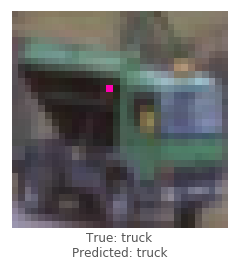


Iteration 49
Attacking image 7743
Confidence: 0.9964886
Confidence: 0.99633956
Confidence: 0.9960672
Confidence: 0.9950176
Confidence: 0.97666514
Confidence: 0.9284721
Confidence: 0.9284721
Confidence: 0.925721
Confidence: 0.9250714
Confidence: 0.9175294
Confidence: 0.9175294
Confidence: 0.9175294
Confidence: 0.9175294
Confidence: 0.9175294
Confidence: 0.9163364
Confidence: 0.9156894
Confidence: 0.9156894
Confidence: 0.9156894
Confidence: 0.9156894
Confidence: 0.9156894
Confidence: 0.9156894
Confidence: 0.9156894
Confidence: 0.9156894
Confidence: 0.9156894
Confidence: 0.9156894
Confidence: 0.9156894
Confidence: 0.9156894
Confidence: 0.9156894
Confidence: 0.9156894
Confidence: 0.9156894


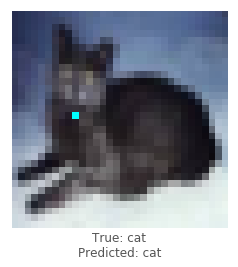


Iteration 50
Attacking image 7942
Confidence: 0.96815735
Confidence: 0.96815735
Confidence: 0.96754676
Confidence: 0.95844823
Confidence: 0.95430696
Confidence: 0.95430696
Confidence: 0.95430696
Confidence: 0.9541831
Confidence: 0.9541831
Confidence: 0.9541831
Confidence: 0.9541831
Confidence: 0.9541831
Confidence: 0.9541831
Confidence: 0.9541831
Confidence: 0.9541831
Confidence: 0.9541831
Confidence: 0.9541831
Confidence: 0.9541831
Confidence: 0.9541831
Confidence: 0.9541831
Confidence: 0.9541831
Confidence: 0.9541831
Confidence: 0.9541831
Confidence: 0.9541831
Confidence: 0.9541831
Confidence: 0.9541831
Confidence: 0.9541831
Confidence: 0.9541831
Confidence: 0.9541831
Confidence: 0.9541831


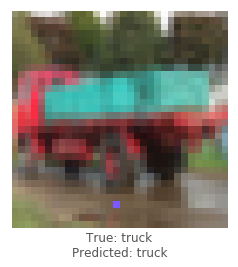


Iteration 51
Attacking image 539
Confidence: 0.9999912
Confidence: 0.9999912
Confidence: 0.9999912
Confidence: 0.99999106
Confidence: 0.99999106
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908
Confidence: 0.9999908


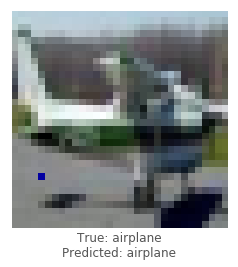


Iteration 52
Attacking image 5479
Confidence: 0.99918526
Confidence: 0.99918526
Confidence: 0.9987025
Confidence: 0.99200433
Confidence: 0.971771
Confidence: 0.971771
Confidence: 0.971771
Confidence: 0.971771
Confidence: 0.971771
Confidence: 0.97130245
Confidence: 0.97087497
Confidence: 0.96874017
Confidence: 0.96874017
Confidence: 0.96874017
Confidence: 0.96874017
Confidence: 0.96835136
Confidence: 0.96835136
Confidence: 0.96799
Confidence: 0.9677921
Confidence: 0.9677921
Confidence: 0.9677921
Confidence: 0.9677921
Confidence: 0.9677921
Confidence: 0.9677921
Confidence: 0.9677921
Confidence: 0.9677921
Confidence: 0.9677921
Confidence: 0.9677921
Confidence: 0.9677921
Confidence: 0.9677921


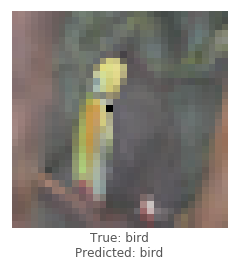


Iteration 53
Attacking image 6493
Confidence: 0.99989855
Confidence: 0.99989855
Confidence: 0.99989283
Confidence: 0.9998858
Confidence: 0.9998839
Confidence: 0.9998826
Confidence: 0.9998826
Confidence: 0.9998826
Confidence: 0.9998821
Confidence: 0.9998821
Confidence: 0.99988186
Confidence: 0.99988186
Confidence: 0.99988186
Confidence: 0.99988186
Confidence: 0.99988186
Confidence: 0.99988186
Confidence: 0.99988186
Confidence: 0.99988186
Confidence: 0.99988186
Confidence: 0.99988186
Confidence: 0.99988186
Confidence: 0.99988186
Confidence: 0.99988186
Confidence: 0.99988186
Confidence: 0.99988186
Confidence: 0.99988186
Confidence: 0.99988186
Confidence: 0.99988186
Confidence: 0.99988186
Confidence: 0.99988186


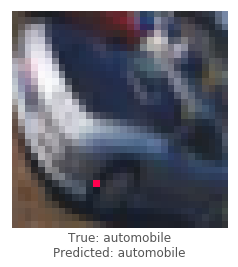


Iteration 54
Attacking image 9183
Confidence: 0.9999938
Confidence: 0.99999166
Confidence: 0.99999034
Confidence: 0.9999901
Confidence: 0.99999
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896
Confidence: 0.9999896


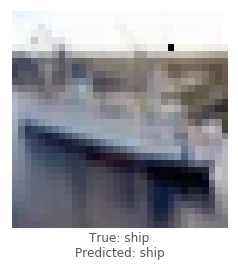


Iteration 55
Attacking image 9697
Confidence: 0.9695236
Confidence: 0.9695236
Confidence: 0.9345905
Confidence: 0.92202556
Confidence: 0.91258687
Confidence: 0.91258687
Confidence: 0.91258687
Confidence: 0.91258687
Confidence: 0.9119401
Confidence: 0.9113839
Confidence: 0.9113839
Confidence: 0.9113839
Confidence: 0.91110176
Confidence: 0.91110176
Confidence: 0.91110176
Confidence: 0.91110176
Confidence: 0.91110176
Confidence: 0.91110176
Confidence: 0.91110176
Confidence: 0.91110176
Confidence: 0.91110176
Confidence: 0.91110176
Confidence: 0.91110176
Confidence: 0.91110176
Confidence: 0.91110176
Confidence: 0.91110176
Confidence: 0.91110176
Confidence: 0.91110176
Confidence: 0.91110176
Confidence: 0.91110176


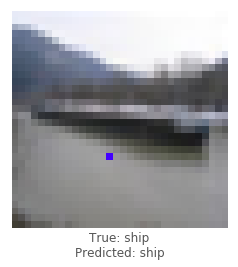


Iteration 56
Attacking image 5847
Confidence: 0.9998617
Confidence: 0.99986076
Confidence: 0.9998393
Confidence: 0.99979967
Confidence: 0.9997985
Confidence: 0.99979526
Confidence: 0.9997948
Confidence: 0.99979347
Confidence: 0.99979347
Confidence: 0.9997931
Confidence: 0.9997917
Confidence: 0.99979025
Confidence: 0.99979025
Confidence: 0.99979025
Confidence: 0.99979025
Confidence: 0.99979025
Confidence: 0.99979025
Confidence: 0.99979025
Confidence: 0.99979
Confidence: 0.99979
Confidence: 0.99979
Confidence: 0.99979
Confidence: 0.99979
Confidence: 0.99979
Confidence: 0.99979
Confidence: 0.99979
Confidence: 0.99979
Confidence: 0.99979
Confidence: 0.99979
Confidence: 0.99979


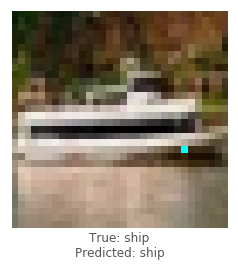


Iteration 57
Attacking image 3415
Confidence: 0.052654877


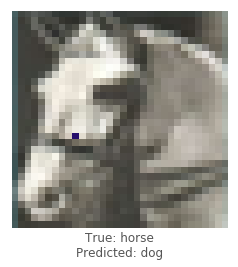


Iteration 58
Attacking image 698
Confidence: 0.999982
Confidence: 0.9999808
Confidence: 0.9999783
Confidence: 0.9999757
Confidence: 0.99997556
Confidence: 0.99997413
Confidence: 0.99997413
Confidence: 0.9999739
Confidence: 0.9999734
Confidence: 0.9999734
Confidence: 0.9999733
Confidence: 0.9999733
Confidence: 0.9999733
Confidence: 0.9999732
Confidence: 0.9999732
Confidence: 0.9999732
Confidence: 0.9999732
Confidence: 0.9999732
Confidence: 0.9999732
Confidence: 0.9999732
Confidence: 0.9999732
Confidence: 0.9999732
Confidence: 0.9999732
Confidence: 0.9999732
Confidence: 0.9999732
Confidence: 0.9999732
Confidence: 0.9999732
Confidence: 0.9999732
Confidence: 0.9999732
Confidence: 0.9999732


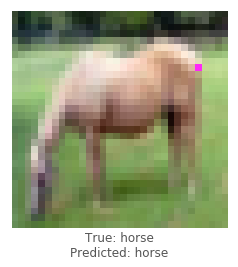


Iteration 59
Attacking image 8193
Confidence: 0.81174195
Confidence: 0.58186984
Confidence: 0.5138434
Confidence: 0.4988635
Confidence: 0.4952424


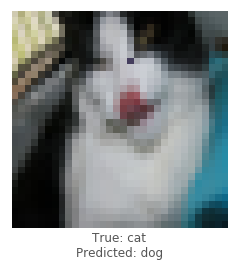


Iteration 60
Attacking image 8593
Confidence: 0.9999199
Confidence: 0.9999068
Confidence: 0.9999038
Confidence: 0.9998635
Confidence: 0.99986255
Confidence: 0.9998615
Confidence: 0.9998615
Confidence: 0.9998615
Confidence: 0.9998615
Confidence: 0.9998615
Confidence: 0.99986124
Confidence: 0.99986124
Confidence: 0.99986124
Confidence: 0.9998611
Confidence: 0.9998611
Confidence: 0.9998611
Confidence: 0.9998611
Confidence: 0.9998611
Confidence: 0.9998611
Confidence: 0.9998611
Confidence: 0.9998611
Confidence: 0.9998611
Confidence: 0.9998611
Confidence: 0.9998611
Confidence: 0.9998611
Confidence: 0.9998611
Confidence: 0.9998611
Confidence: 0.9998611
Confidence: 0.9998611
Confidence: 0.9998611


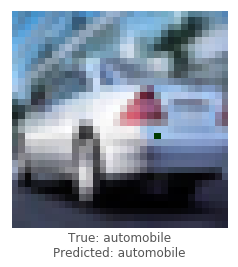


Iteration 61
Attacking image 3222
Confidence: 0.90137017
Confidence: 0.90137017
Confidence: 0.8430603
Confidence: 0.82802707
Confidence: 0.8248537
Confidence: 0.822641
Confidence: 0.822641
Confidence: 0.8218053
Confidence: 0.8212231
Confidence: 0.8210934
Confidence: 0.8210226
Confidence: 0.8210226
Confidence: 0.8210165
Confidence: 0.8210165
Confidence: 0.8210165
Confidence: 0.8210165
Confidence: 0.8210165
Confidence: 0.8210165
Confidence: 0.8210165
Confidence: 0.8210165
Confidence: 0.8210165
Confidence: 0.8210165
Confidence: 0.8210165
Confidence: 0.8210165
Confidence: 0.8210165
Confidence: 0.8210165
Confidence: 0.8210165
Confidence: 0.8210165
Confidence: 0.8210165
Confidence: 0.8210165


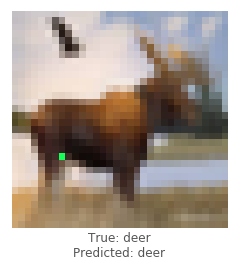


Iteration 62
Attacking image 9967
Confidence: 0.0041368515


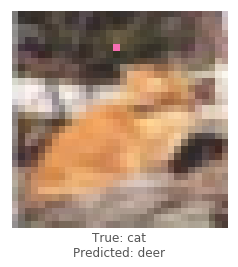


Iteration 63
Attacking image 5350
Confidence: 0.9998541
Confidence: 0.99980634
Confidence: 0.9995865
Confidence: 0.99911815
Confidence: 0.99870014
Confidence: 0.99869007
Confidence: 0.99850523
Confidence: 0.99850523
Confidence: 0.99850523
Confidence: 0.99849653
Confidence: 0.9984687
Confidence: 0.9984687
Confidence: 0.9984611
Confidence: 0.9984493
Confidence: 0.9984493
Confidence: 0.9984493
Confidence: 0.9984493
Confidence: 0.9984493
Confidence: 0.9984493
Confidence: 0.9984493
Confidence: 0.9984493
Confidence: 0.9984493
Confidence: 0.9984493
Confidence: 0.9984493
Confidence: 0.9984493
Confidence: 0.9984493
Confidence: 0.9984493
Confidence: 0.9984493
Confidence: 0.9984493
Confidence: 0.9984493


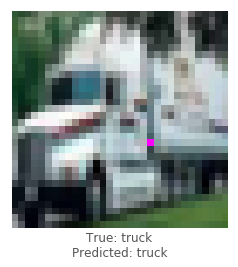


Iteration 64
Attacking image 8003
Confidence: 0.24212739


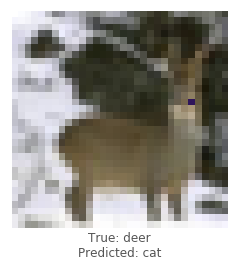


Iteration 65
Attacking image 1580
Confidence: 0.039220687


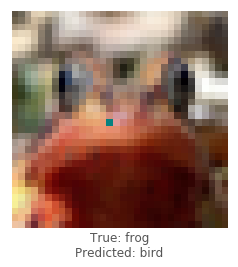


Iteration 66
Attacking image 6202
Confidence: 0.0020505646


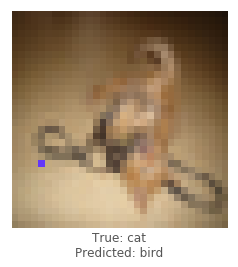


Iteration 67
Attacking image 7059
Confidence: 0.014172038


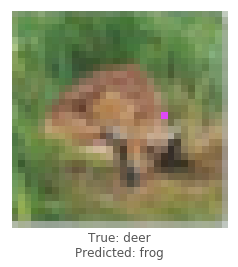


Iteration 68
Attacking image 728
Confidence: 0.9622335
Confidence: 0.91671544
Confidence: 0.8933212
Confidence: 0.884371
Confidence: 0.8759867
Confidence: 0.83716387
Confidence: 0.83537996
Confidence: 0.83537996
Confidence: 0.83537996
Confidence: 0.8346014
Confidence: 0.8346014
Confidence: 0.8304416
Confidence: 0.82690954
Confidence: 0.82690954
Confidence: 0.82690954
Confidence: 0.82690954
Confidence: 0.82690954
Confidence: 0.82690954
Confidence: 0.82673717
Confidence: 0.82673717
Confidence: 0.82673717
Confidence: 0.82673717
Confidence: 0.82673717
Confidence: 0.82673717
Confidence: 0.82673717
Confidence: 0.82673717
Confidence: 0.82673717
Confidence: 0.82673717
Confidence: 0.82673717
Confidence: 0.82673717


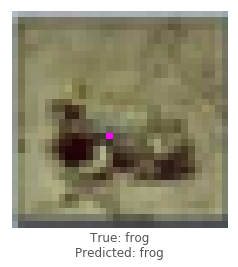


Iteration 69
Attacking image 7487
Confidence: 0.9934186
Confidence: 0.9928463
Confidence: 0.9928463
Confidence: 0.992646
Confidence: 0.99258924
Confidence: 0.99258924
Confidence: 0.99258924
Confidence: 0.99258924
Confidence: 0.99258924
Confidence: 0.9925801
Confidence: 0.99257314
Confidence: 0.9925718
Confidence: 0.99257165
Confidence: 0.99257165
Confidence: 0.99257165
Confidence: 0.99257165
Confidence: 0.99257165
Confidence: 0.99257165
Confidence: 0.99257165
Confidence: 0.99257165
Confidence: 0.99257165
Confidence: 0.99257165
Confidence: 0.99257165
Confidence: 0.99257165
Confidence: 0.99257165
Confidence: 0.99257165
Confidence: 0.99257165
Confidence: 0.99257165
Confidence: 0.99257165
Confidence: 0.99257165


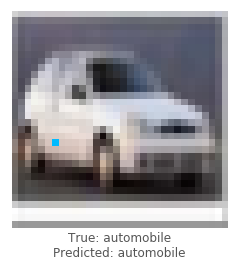


Iteration 70
Attacking image 4543
Confidence: 0.99998045
Confidence: 0.99998045
Confidence: 0.9999801
Confidence: 0.99998
Confidence: 0.99998
Confidence: 0.99997985
Confidence: 0.99997985
Confidence: 0.99997985
Confidence: 0.99997985
Confidence: 0.99997985
Confidence: 0.99997985
Confidence: 0.99997973
Confidence: 0.99997973
Confidence: 0.99997973
Confidence: 0.99997973
Confidence: 0.99997973
Confidence: 0.99997973
Confidence: 0.99997973
Confidence: 0.99997973
Confidence: 0.99997973
Confidence: 0.99997973
Confidence: 0.99997973
Confidence: 0.99997973
Confidence: 0.99997973
Confidence: 0.99997973
Confidence: 0.99997973
Confidence: 0.99997973
Confidence: 0.99997973
Confidence: 0.99997973
Confidence: 0.99997973


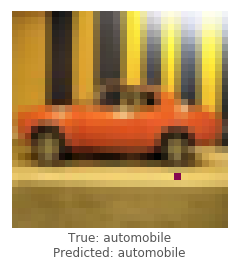


Iteration 71
Attacking image 4624
Confidence: 0.005672092


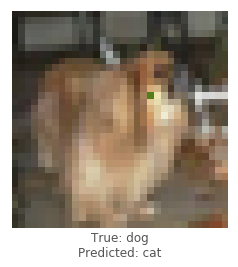


Iteration 72
Attacking image 7581
Confidence: 0.9998815
Confidence: 0.9997857
Confidence: 0.9997335
Confidence: 0.9997335
Confidence: 0.9997335
Confidence: 0.9997335
Confidence: 0.9997335
Confidence: 0.99970204
Confidence: 0.99970204
Confidence: 0.99970204
Confidence: 0.99970204
Confidence: 0.99970204
Confidence: 0.99970204
Confidence: 0.9997004
Confidence: 0.9996966
Confidence: 0.99969566
Confidence: 0.99969494
Confidence: 0.99969363
Confidence: 0.99969363
Confidence: 0.9996934
Confidence: 0.9996934
Confidence: 0.9996934
Confidence: 0.9996934
Confidence: 0.9996934
Confidence: 0.9996934
Confidence: 0.9996934
Confidence: 0.9996934
Confidence: 0.9996934
Confidence: 0.9996934
Confidence: 0.9996934


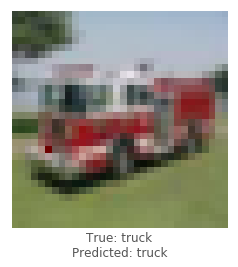


Iteration 73
Attacking image 5958
Confidence: 0.9996871
Confidence: 0.9996828
Confidence: 0.99964297
Confidence: 0.99939954
Confidence: 0.99939656
Confidence: 0.99932635
Confidence: 0.9992556
Confidence: 0.9992286
Confidence: 0.9990988
Confidence: 0.9990988
Confidence: 0.9990908
Confidence: 0.9990908
Confidence: 0.9990747
Confidence: 0.9990717
Confidence: 0.99907124
Confidence: 0.9990711
Confidence: 0.9990711
Confidence: 0.9990711
Confidence: 0.9990711
Confidence: 0.9990711
Confidence: 0.9990711
Confidence: 0.9990711
Confidence: 0.9990711
Confidence: 0.9990711
Confidence: 0.9990711
Confidence: 0.9990711
Confidence: 0.9990711
Confidence: 0.9990711
Confidence: 0.9990711
Confidence: 0.9990711


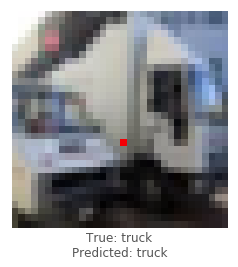


Iteration 74
Attacking image 5326
Confidence: 0.99965346
Confidence: 0.99941444
Confidence: 0.99933356
Confidence: 0.99930716
Confidence: 0.99919766
Confidence: 0.99914646
Confidence: 0.9991416
Confidence: 0.9991416
Confidence: 0.9991308
Confidence: 0.9991154
Confidence: 0.99911517
Confidence: 0.99911505
Confidence: 0.99911505
Confidence: 0.99911505
Confidence: 0.99911505
Confidence: 0.99911505
Confidence: 0.99911505
Confidence: 0.99911505
Confidence: 0.99911505
Confidence: 0.99911505
Confidence: 0.99911505
Confidence: 0.99911505
Confidence: 0.99911505
Confidence: 0.99911505
Confidence: 0.99911505
Confidence: 0.99911505
Confidence: 0.99911505
Confidence: 0.99911505
Confidence: 0.99911505
Confidence: 0.99911505


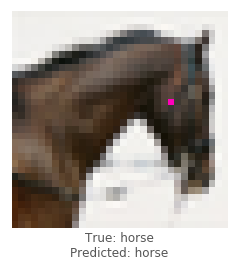


Iteration 75
Attacking image 7460
Confidence: 0.98928714
Confidence: 0.90269387
Confidence: 0.87364024
Confidence: 0.86841327
Confidence: 0.8155947
Confidence: 0.8155947
Confidence: 0.8155947
Confidence: 0.8155947
Confidence: 0.81078625
Confidence: 0.800264
Confidence: 0.800264
Confidence: 0.7881599
Confidence: 0.78713644
Confidence: 0.7866449
Confidence: 0.7866449
Confidence: 0.7865576
Confidence: 0.7865576
Confidence: 0.7865576
Confidence: 0.7865576
Confidence: 0.7865576
Confidence: 0.7865576
Confidence: 0.7865576
Confidence: 0.7865576
Confidence: 0.7865576
Confidence: 0.7865576
Confidence: 0.7865576
Confidence: 0.7865576
Confidence: 0.7865576
Confidence: 0.7865576
Confidence: 0.7865576


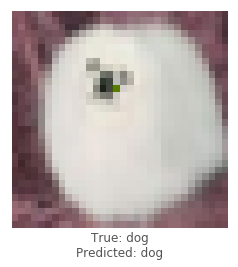


Iteration 76
Attacking image 2466
Confidence: 0.95963204
Confidence: 0.94719946
Confidence: 0.9420143
Confidence: 0.9420143
Confidence: 0.9395337
Confidence: 0.93398273
Confidence: 0.9228223
Confidence: 0.9209736
Confidence: 0.9209736
Confidence: 0.92085695
Confidence: 0.92085695
Confidence: 0.9207874
Confidence: 0.9207874
Confidence: 0.9207874
Confidence: 0.92077535
Confidence: 0.92074424
Confidence: 0.92074424
Confidence: 0.92074424
Confidence: 0.92074424
Confidence: 0.92074424
Confidence: 0.92074424
Confidence: 0.92074424
Confidence: 0.92074424
Confidence: 0.92074424
Confidence: 0.92074424
Confidence: 0.92074424
Confidence: 0.92074424
Confidence: 0.92074424
Confidence: 0.92074424
Confidence: 0.92074424


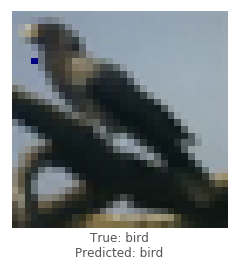


Iteration 77
Attacking image 3845
Confidence: 0.999933
Confidence: 0.9999138
Confidence: 0.99991083
Confidence: 0.9999056
Confidence: 0.9998933
Confidence: 0.9998933
Confidence: 0.9998933
Confidence: 0.9998933
Confidence: 0.9998933
Confidence: 0.9998933
Confidence: 0.9998933
Confidence: 0.9998932
Confidence: 0.9998932
Confidence: 0.9998932
Confidence: 0.9998932
Confidence: 0.9998932
Confidence: 0.9998932
Confidence: 0.9998932
Confidence: 0.9998932
Confidence: 0.9998932
Confidence: 0.9998932
Confidence: 0.9998932
Confidence: 0.9998932
Confidence: 0.9998932
Confidence: 0.9998932
Confidence: 0.9998932
Confidence: 0.9998932
Confidence: 0.9998932
Confidence: 0.9998932
Confidence: 0.9998932


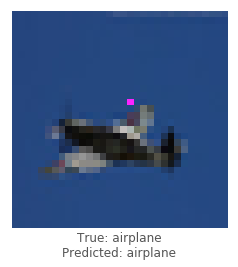


Iteration 78
Attacking image 717
Confidence: 0.99340534
Confidence: 0.99235535
Confidence: 0.9816243
Confidence: 0.9816243
Confidence: 0.98149234
Confidence: 0.98024493
Confidence: 0.9799216
Confidence: 0.9799216
Confidence: 0.9799216
Confidence: 0.9799216
Confidence: 0.9799216
Confidence: 0.9799216
Confidence: 0.9799216
Confidence: 0.9799216
Confidence: 0.9799216
Confidence: 0.9799216
Confidence: 0.9799216
Confidence: 0.9799216
Confidence: 0.9799216
Confidence: 0.9799216
Confidence: 0.9799216
Confidence: 0.9799216
Confidence: 0.9799216
Confidence: 0.9799216
Confidence: 0.9799216
Confidence: 0.9799216
Confidence: 0.9799216
Confidence: 0.9799216
Confidence: 0.9799216
Confidence: 0.9799216


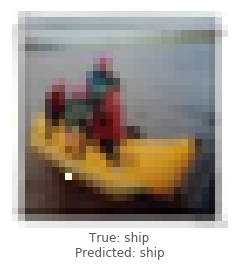


Iteration 79
Attacking image 8719
Confidence: 0.9987631
Confidence: 0.9986602
Confidence: 0.9983789
Confidence: 0.9983736
Confidence: 0.99837047
Confidence: 0.9983034
Confidence: 0.9982481
Confidence: 0.99824715
Confidence: 0.99822336
Confidence: 0.99822
Confidence: 0.99820995
Confidence: 0.99820626
Confidence: 0.99820626
Confidence: 0.99820626
Confidence: 0.99820626
Confidence: 0.99820626
Confidence: 0.99820626
Confidence: 0.99820626
Confidence: 0.99820626
Confidence: 0.99820626
Confidence: 0.99820626
Confidence: 0.99820626
Confidence: 0.99820626
Confidence: 0.99820626
Confidence: 0.99820626
Confidence: 0.99820626
Confidence: 0.99820626
Confidence: 0.99820626
Confidence: 0.99820626
Confidence: 0.99820626


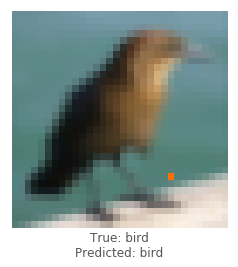


Iteration 80
Attacking image 4
Confidence: 0.9998673
Confidence: 0.99982363
Confidence: 0.9998154
Confidence: 0.9998154
Confidence: 0.99979657
Confidence: 0.99979657
Confidence: 0.99979657
Confidence: 0.99979657
Confidence: 0.99979585
Confidence: 0.99979585
Confidence: 0.99979585
Confidence: 0.99979585
Confidence: 0.99979323
Confidence: 0.99979323
Confidence: 0.99979323
Confidence: 0.99979323
Confidence: 0.99979323
Confidence: 0.99979323
Confidence: 0.99979323
Confidence: 0.99979323
Confidence: 0.99979323
Confidence: 0.99979323
Confidence: 0.99979323
Confidence: 0.99979323
Confidence: 0.99979323
Confidence: 0.99979323
Confidence: 0.99979323
Confidence: 0.99979323
Confidence: 0.99979323
Confidence: 0.99979323


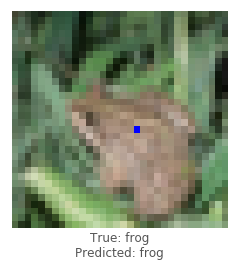


Iteration 81
Attacking image 8687
Confidence: 0.9998896
Confidence: 0.9998896
Confidence: 0.9995976
Confidence: 0.9978103
Confidence: 0.9964568
Confidence: 0.99495924
Confidence: 0.99458283
Confidence: 0.99458283
Confidence: 0.99209267
Confidence: 0.99108315
Confidence: 0.9905262
Confidence: 0.9905262
Confidence: 0.9905262
Confidence: 0.9905262
Confidence: 0.9905262
Confidence: 0.9905262
Confidence: 0.9905262
Confidence: 0.9905262
Confidence: 0.9905262
Confidence: 0.9905262
Confidence: 0.9905262
Confidence: 0.9905262
Confidence: 0.9905262
Confidence: 0.9905262
Confidence: 0.9905262
Confidence: 0.9905262
Confidence: 0.9905262
Confidence: 0.9905262
Confidence: 0.9905262
Confidence: 0.9905262


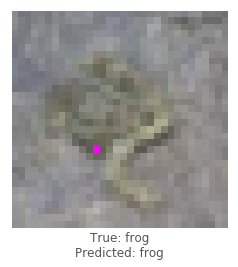


Iteration 82
Attacking image 2860
Confidence: 0.9997888
Confidence: 0.9997888
Confidence: 0.9997888
Confidence: 0.99966395
Confidence: 0.99966395
Confidence: 0.99966395
Confidence: 0.9995907
Confidence: 0.9995907
Confidence: 0.999483
Confidence: 0.9994654
Confidence: 0.9994654
Confidence: 0.9994654
Confidence: 0.9994654
Confidence: 0.9994654
Confidence: 0.9994654
Confidence: 0.9994641
Confidence: 0.9994603
Confidence: 0.9994603
Confidence: 0.9994406
Confidence: 0.9994406
Confidence: 0.9994406
Confidence: 0.9994406
Confidence: 0.9994406
Confidence: 0.9994406
Confidence: 0.9994406
Confidence: 0.9994406
Confidence: 0.9994406
Confidence: 0.9994406
Confidence: 0.9994406
Confidence: 0.9994406


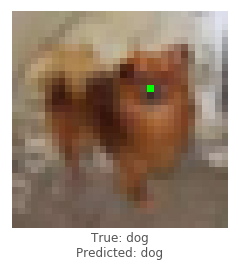


Iteration 83
Attacking image 9111
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976
Confidence: 0.99999976


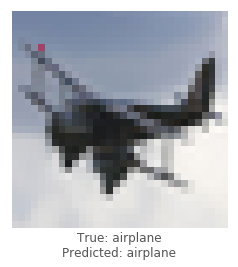


Iteration 84
Attacking image 3219
Confidence: 0.11078459


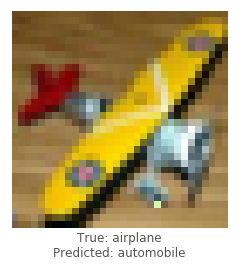


Iteration 85
Attacking image 2351
Confidence: 0.0018433447


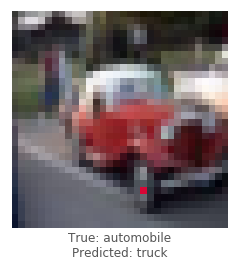


Iteration 86
Attacking image 1489
Confidence: 0.9969374
Confidence: 0.9951749
Confidence: 0.9845948
Confidence: 0.9845948
Confidence: 0.9789524
Confidence: 0.97303325
Confidence: 0.97238433
Confidence: 0.95355636
Confidence: 0.95355636
Confidence: 0.9526937
Confidence: 0.9526937
Confidence: 0.9526937
Confidence: 0.9526937
Confidence: 0.9526937
Confidence: 0.95139945
Confidence: 0.95034224
Confidence: 0.94885534
Confidence: 0.94885534
Confidence: 0.9487415
Confidence: 0.9487415
Confidence: 0.9487415
Confidence: 0.9487415
Confidence: 0.9487415
Confidence: 0.9487415
Confidence: 0.9487415
Confidence: 0.9487415
Confidence: 0.9487415
Confidence: 0.9487415
Confidence: 0.9487415
Confidence: 0.9487415


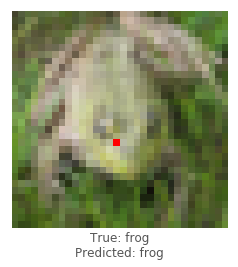


Iteration 87
Attacking image 3828
Confidence: 0.0013942658


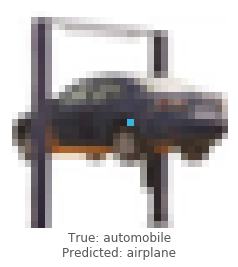


Iteration 88
Attacking image 2
Confidence: 0.08314706


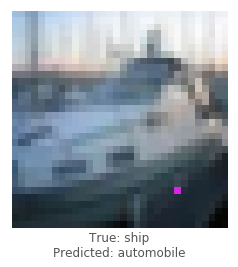


Iteration 89
Attacking image 3324
Confidence: 0.9998605
Confidence: 0.9998605
Confidence: 0.99984264
Confidence: 0.9998392
Confidence: 0.9998392
Confidence: 0.99983656
Confidence: 0.99983466
Confidence: 0.99983466
Confidence: 0.99983394
Confidence: 0.9998336
Confidence: 0.9998332
Confidence: 0.9998332
Confidence: 0.999833
Confidence: 0.999833
Confidence: 0.999833
Confidence: 0.999833
Confidence: 0.999833
Confidence: 0.999833
Confidence: 0.999833
Confidence: 0.999833
Confidence: 0.999833
Confidence: 0.999833
Confidence: 0.999833
Confidence: 0.999833
Confidence: 0.999833
Confidence: 0.999833
Confidence: 0.999833
Confidence: 0.999833
Confidence: 0.999833
Confidence: 0.999833


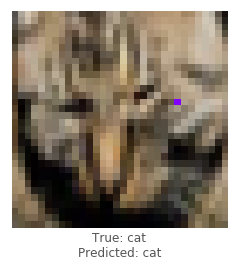


Iteration 90
Attacking image 3647


KeyboardInterrupt: 

In [50]:
untargeted_results = attack_untargeted(wide_resnet)

In [45]:
untargeted_results

,image_index,true_class,predicted_class,success,predicted_probs,attack_image
0,6434,0,0,False,"[0.93864465, 0.0014470723, 9.012594e-05, 6.175...","[[[98, 166, 189], [101, 168, 191], [105, 173, ..."
1,848,2,2,False,"[0.37613243, 0.0012377605, 0.61433303, 0.00294...","[[[80, 80, 70], [76, 73, 64], [73, 69, 60], [8..."
2,6620,7,7,False,"[3.4860837e-05, 2.2225837e-05, 2.4331144e-05, ...","[[[7, 7, 9], [4, 3, 5], [4, 4, 6], [6, 6, 8], ..."


### Targeted Attack

In [65]:
def attack_targeted(model, pixel_count=1, sample_count=100, iterations=30,
                      population=100, mutation=0.5, recombination=1, 
                      stop_threshold=-0.01, callback=None):
    samples = np.random.choice(len(x_test), sample_count)
    
    results = []
    for i,img in enumerate(samples):
        print()
        print('Iteration', i)
        for target in range(10):
            if target == y_test[img]:
                continue
            print()
            print('Attacking image', img, 'with target', target, class_names[target])
            
            actual_class = y_test[img][0]
        
            plot_image(x_test[img], actual_class, class_names)
            
            args = x_test[img], target, model
            bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
            attack = predict_targeted

            res = differential_evolution(attack, bounds, args=args, maxiter=iterations, popsize=population, mutation=0.5, recombination=0.5, atol=stop_threshold, disp=True)

            attack_image = perturb_image(res.x, x_test[img])
            predicted_probs = model.predict(attack_image)
            predicted_class = np.argmax(predicted_probs)
            
            plot_image(attack_image, actual_class, class_names, predicted_class)

            result = img, predicted_class, actual_class, predicted_probs, attack_image
            results.append(result)
        
    return results

In [ ]:
def untargeted_callback(xk, convergence):
    print(xk)

Targeting model wide_resnet
Attacking image 6521 with target 0 airplane


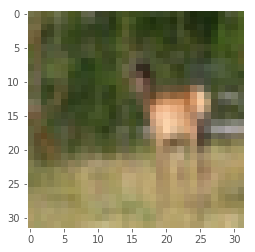

differential_evolution step 1: f(x)= 0.999988
differential_evolution step 2: f(x)= 0.999985
differential_evolution step 3: f(x)= 0.999982
differential_evolution step 4: f(x)= 0.999944
differential_evolution step 5: f(x)= 0.999944
differential_evolution step 6: f(x)= 0.999944


KeyboardInterrupt: 

In [66]:
targeted_results = attack_targeted(models[0])
targeted_results

### Show some successful attacks

Plot the first 9 misclassified images

## Credits
 - Base code taken from https://github.com/09rohanchopra/cifar10
 - https://arxiv.org/pdf/1412.6806.pdf
 - https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py
 - https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/06_CIFAR-10.ipynb
 - http://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/
 - https://parneetk.github.io/blog/cnn-cifar10/
 - https://github.com/dnlcrl/deep-residual-networks-pyfunt/blob/master/docs/CIFAR-10%20Experiments.ipynb